<a href="https://colab.research.google.com/github/hcarlens/DQN/blob/master/Simple_DQN_on_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install the OpenAI gym
!pip install gym

    100% |████████████████████████████████| 1.5MB 8.2MB/s 
    100% |████████████████████████████████| 1.0MB 13.0MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym


In [0]:
# import the necessary packages
import numpy as np
import gym
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [4]:
# set hyperparameters (mostly taken from DQN paper)
num_episodes = 1000
max_num_steps = 200
start_epsilon = 1
end_epsilon = 0.01
epsilon_decay_rate = 0.99
discount_rate = 1
batch_size = 32
optimizer_learning_rate = 0.01
buffer_length = 50000
target_update_steps = 10000

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [0]:
# define Q-network (two layers with 32 neurons each)
# 4 inputs (one for each scalar observable) +1 to represent the action
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu,
                       input_shape=(5,)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(learning_rate=optimizer_learning_rate)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [0]:
# define a memory buffer
class MemoryBuffer:
  def __init__(self):
    self.experience_buffer = deque(maxlen=buffer_length)

  def add_memory(self, memory):
    self.experience_buffer.append(memory)
    
  def sample_minibatch(self, batch_size):
    # sample from experience buffer
    minibatch = random.sample(self.experience_buffer, min(len(self.experience_buffer), batch_size))
    input_cache = []
    label_cache = []

    # parse all the relevant states in our replay buffer
    for state, action, reward, next_state, done in minibatch:
        if done: 
            target_q_value = reward
        else:         
            max_q_next_state = max(q_network.predict(np.array([np.append(next_state,0), np.append(next_state,1)])))[0]
            
            target_q_value = reward + discount_rate * max_q_next_state

        input_cache.append(np.append(state, action))
        label_cache.append(np.array(target_q_value))
    return input_cache, label_cache

In [7]:
# initialise environment, required objects, and some variables
env = gym.make('CartPole-v0')

q_network = build_model()
memory_buffer = MemoryBuffer()

epsilon = start_epsilon
episode_lengths = []
total_steps = 0


# run through episodes
for e in range(num_episodes):
    observation = env.reset()
    
    for t in range(max_num_steps):
        input = np.array([np.append(observation,0), np.append(observation,1)])

        # with probability epsilon, choose a random action
        # otherwise use Q-network to pick action 
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_network.predict(input))

        next_observation, reward, done, info = env.step(action)
        
        # add memory to buffer
        memory = (observation, action, reward, next_observation, done)
        memory_buffer.add_memory(memory)
        
        # sample a minibatch of experiences and update q-network
        minibatch_inputs, minibatch_q_values = memory_buffer.sample_minibatch(batch_size)
        q_network.fit(np.array(minibatch_inputs), np.array(minibatch_q_values), verbose=0)
        
        observation = next_observation
        total_steps += 1
        if done or t == max_num_steps - 1:
            break 
            
    episode_lengths.append(t)
    print("Episode {} finished after {} timesteps. 100 ep running avg {}. Epsilon {}. ".format(e, t+1, np.floor(np.average(episode_lengths[-100:])), epsilon))

    # decrease epsilon value
    epsilon = max(epsilon * epsilon_decay_rate, end_epsilon)


Episode 0 finished after 13 timesteps. 100 ep running avg 12.0. Epsilon 1. 
Episode 1 finished after 21 timesteps. 100 ep running avg 16.0. Epsilon 0.99. 
Episode 2 finished after 17 timesteps. 100 ep running avg 16.0. Epsilon 0.9801. 
Episode 3 finished after 17 timesteps. 100 ep running avg 16.0. Epsilon 0.9702989999999999. 
Episode 4 finished after 10 timesteps. 100 ep running avg 14.0. Epsilon 0.96059601. 
Episode 5 finished after 48 timesteps. 100 ep running avg 20.0. Epsilon 0.9509900498999999. 
Episode 6 finished after 11 timesteps. 100 ep running avg 18.0. Epsilon 0.9414801494009999. 
Episode 7 finished after 39 timesteps. 100 ep running avg 21.0. Epsilon 0.9320653479069899. 
Episode 8 finished after 21 timesteps. 100 ep running avg 20.0. Epsilon 0.92274469442792. 
Episode 9 finished after 11 timesteps. 100 ep running avg 19.0. Epsilon 0.9135172474836407. 
Episode 10 finished after 18 timesteps. 100 ep running avg 19.0. Epsilon 0.9043820750088043. 
Episode 11 finished after 11 

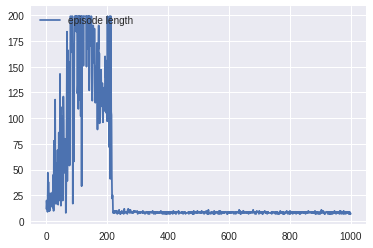

In [8]:
plt.plot(episode_lengths,label='episode length')
plt.legend(loc='upper left')